# Fitting a Straight Line on 2D Data in PyTorch

The objective here is to fit a straight line on a synthetic 2-dimensional or 2D data. 

This is known as a **Linear Regression Problem**.


In [1]:
# Importing the bare necessities...

import random
import numpy as np


from sklearn.metrics import r2_score
import scipy.stats as stats

from matplotlib import pyplot as plt
%matplotlib inline

import torch

seed_for_reproducibility = 3333
random.seed(seed_for_reproducibility)
np.random.seed(seed_for_reproducibility)
torch.manual_seed(seed_for_reproducibility)

> ## STEP 1: Generating Synthetic 2D data

> In order to find a straight line that fits a given data, we first need to generate the data itself. We are going to generate the synthetic data in such a way that the data points roughly lie on a stright line. We are going to do this by using some predefined **m** (slope) and **c** (intercept).

In [2]:
# Defining the number of data points to be generated
num_points = 10000

# Defining the range of 'x', the independent variable
x_range = [-2000, 2000]

# Defining the extent of noise, which would be added to both the dependent as well as the independent variable
deviation = 100

# For the data points to roughly fall on a staright line, we need to define the slope and the intercept of that line
# Let's intoduce some randomness in the slope and intercept selection process
m_synthetic = random.randint(-100, 100)/100. # m_synthetic is real number from the set(-1.0, -0.99, -0.98 ...., 0.98, 0.99, 1.0)
c_synthetic = random.randint(-100, 100)        # c_synthetic is an integer from the set(-100, -999, -998 ..., 998, 999, 100)

print('\nm_synthetic: {}'.format(m_synthetic))
print('c_synthetic: {}'.format(c_synthetic))

# Let's generate the synthetic data points
x_list = []
y_list = []
for _ in range(num_points):
    
    # Selecting a random integer from the predefined range
    x = random.randint(x_range[0] , x_range[1])
    
    # Calculating the dependent valiable 'y' using the formula of a straight line y = mx + c
    y = m_synthetic*x + c_synthetic
    
    # Randomly choosing the deviation (noise) for both the dependent as well as the independent variable, so that the dataset becomes a little noisy
    deviation_x = random.randint(-deviation , deviation)
    deviation_y = random.randint(-deviation , deviation)
    
    # Finally, appending the noisy data points in the respective lists
    x_list.append(x + deviation_x)
    y_list.append(y + deviation_y)

x_min, y_min, x_max, y_max = min(x_list) , min(y_list) , max(x_list) , max(y_list)
print('\nFollowing are the extreme ends of the synthetic data points...')
print('x_min, x_max: {}, {}'.format(x_min, x_max))
print('y_min, y_max: {}, {}'.format(y_min, y_max))


m_synthetic: -0.67
c_synthetic: 33

Following are the extreme ends of the synthetic data points...
x_min, x_max: -2084, 2087
y_min, y_max: -1403.3300000000002, 1464.65


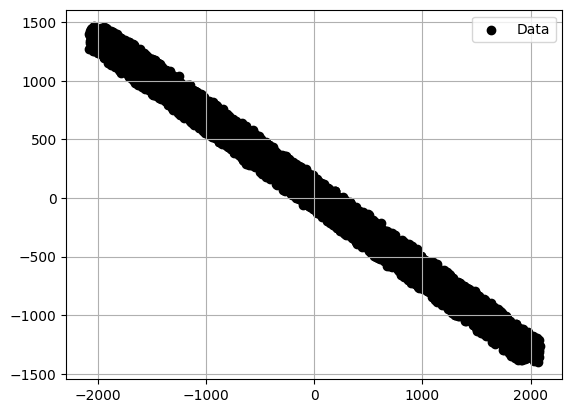

In [3]:
plt.scatter(x_list, y_list , color = 'black', label="Data")
plt.legend()
plt.grid()
plt.show()

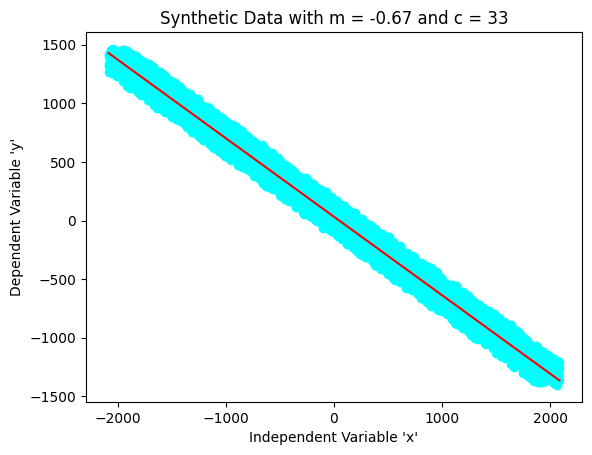

In [4]:
# Let's now visualize how the synthetic data looks like 
plt.scatter(x_list, y_list , color = 'cyan')
plt.plot((x_min, x_max), (m_synthetic*x_min + c_synthetic, m_synthetic*x_max + c_synthetic), color = 'r')
plt.title('Synthetic Data with m = {} and c = {}'.format(m_synthetic, c_synthetic))
plt.xlabel("Independent Variable 'x'")
plt.ylabel("Dependent Variable 'y'")
plt.savefig('./Images/synthetic_m_and_c.jpg')
plt.show()

Our task here, is to find out the equation of a straight line which best fits all the data points !

In other words, we have to find the slope and the intercept of a line, which would give us the line that sits at the center of the distribution of the data points.

Since this is a Linear Regression Problem, we want to find the value of all the required parameters (slope m and intercept c in our case because the data lies in a 2D space)

Had the data been higher-dimensional, we would have to solve for more parameteres.

## STEP 2: Define the model architecture

We are going to use PyTorch to solve this Linear Regression Problem.
We need a very simple model which takes in a single scalar input and spits out some single scalar output.

In [5]:
# Defining the model architecture.
class LinearRegressionModel(torch.nn.Module): 
    def __init__(self): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)  # this layer of the model has a single neuron, that takes in one scalar input and gives out one scalar output. 
  
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 

# Creating the model
model = LinearRegressionModel()

In [6]:
# We can print the 'model' to see it's architecture
print(model)

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Once, we have created the model, let's check out the paramters that we have in it.

There are going to be some learnable parameters in the model, which are randomly initialized at the beginning.

This is the how the initial parameters look like at the initial stage...

In [7]:
for name, parameter in model.named_parameters():
    print('name           : {}'.format(name))
    print('parameter      : {}'.format(parameter.item()))
    print('learnable      : {}'.format(parameter.requires_grad))
    print('parameter.shape: {}'.format(parameter.shape))
    print('---------------------------------')

name           : linear.weight
parameter      : -0.19329047203063965
learnable      : True
parameter.shape: torch.Size([1, 1])
---------------------------------
name           : linear.bias
parameter      : -0.36674630641937256
learnable      : True
parameter.shape: torch.Size([1])
---------------------------------


Note that the parameter's initialized values are not at all, near the m_synthetic and c_synthetic values, which have been actually used to synthesize the data points.

But as we train the model, these values would approach to the values of m_synthetic and c_synthetic ! 

We will see this at the end of this notebook.

## STEP 3: Defining a Loss Fucntion and an Optimizer

There must be a metric which would let us know how well is our model fitting on the given data. 

That is exactly what a **Loss Function** does !

And PyTorch calculates the derivatives of the loss with respect to all the learnable parameters during the Back-Propagation, which is later used by an **Optimizer** to update all the parameters of the model, improving the model after every epoch.

By the way, one **epoch** is when the entire dataset is passed both forward and backward through the Neural Network only once.

In [8]:
# Defining the Loss Function
# Mean Squared Error is the most common choice of Loss Function for Linear Regression models.
criterion = torch.nn.MSELoss()

# Defining the Optimizer, which would update all the trainable parameters of the model, making the model learn the data distribution better and hence fit the distribution better.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005) 

In [9]:
# We also need to convert all the data into tensors before we could use them for training our model.
data_x = torch.tensor([[x] for x in x_list], dtype = torch.float)
data_y = torch.tensor([[y] for y in y_list], dtype = torch.float)

## STEP 4: Training the Model and Plotting the Loss


TRAINING...
loss:  302614.34375
loss:  244502.484375
loss:  195341.28125
loss:  154284.421875
loss:  120421.6796875
loss:  92877.6484375
loss:  70815.7421875
loss:  53443.3515625
loss:  40018.22265625
loss:  29855.23828125
loss:  22333.10546875
loss:  16900.35546875
loss:  13079.0185546875
loss:  10466.40625
loss:  8733.4365234375
loss:  7620.18017578125
loss:  6928.66162109375
loss:  6513.8193359375
loss:  6273.626953125
loss:  6139.328125
loss:  6066.56787109375
loss:  6028.046875
loss:  6007.7177734375
loss:  5996.59619140625
loss:  5989.9189453125
loss:  5985.2744140625
loss:  5981.51171875
loss:  5978.11083984375
loss:  5974.85009765625
loss:  5971.6435546875

Compare the learnt parameters with the original ones

m_synthetic     VS     m_learnt
     -0.67                   -0.6683167815208435

c_synthetic     VS     c_learnt
     33                   1.0940126180648804


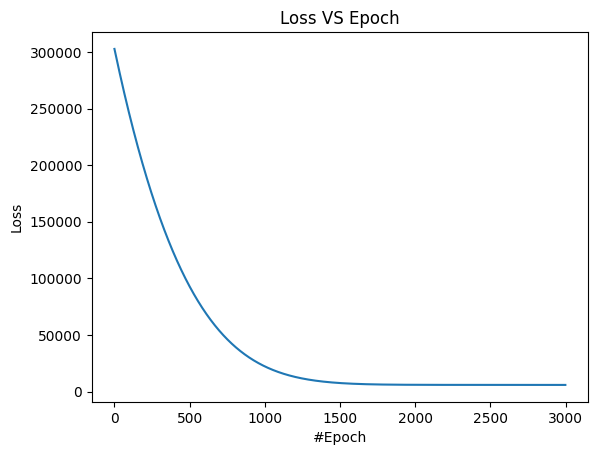

In [10]:
losses = []         # to keep track of the epoch lossese 
slope_list = []     # to keep track of the slope learnt by the model
intercept_list = [] # to keep track of the intercept learnt by the model

EPOCHS = 3000
pred_val_y = []
print('\nTRAINING...')
for epoch in range(EPOCHS):
    # We need to clear the gradients of the optimizer before running the back-propagation in PyTorch
    optimizer.zero_grad() 
    
    # Feeding the input data in the model and getting out the predictions
    pred_y = model(data_x)

    # Calculating the loss using the model's predictions and the real y values
    loss = criterion(pred_y, data_y) 

    # Back-Propagation
    loss.backward() 
    
    # Updating all the trainable parameters
    optimizer.step()
    
    # Appending the loss.item() (a scalar value)
    losses.append(loss.item())

    pred_val_y.append(pred_y.detach())
    # Appending the learnt slope and intercept   
    slope_list.append(model.linear.weight.item())
    intercept_list.append(model.linear.bias.item())
    
    # We print out the losses after every 2000 epochs
    if (epoch)%100 == 0:
        print('loss: ', loss.item())

# Let's see what are the learnt parameters after having trained the model for hundreds of epochs
m_learnt = model.linear.weight.item()
c_learnt = model.linear.bias.item()

print('\nCompare the learnt parameters with the original ones')
print('\nm_synthetic     VS     m_learnt')
print('     {}                   {}'.format(m_synthetic, m_learnt))
print('\nc_synthetic     VS     c_learnt')
print('     {}                   {}'.format(c_synthetic, c_learnt))

# Plotting the epoch losses
plt.plot(losses)
plt.title('Loss VS Epoch')
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.savefig('./Images/losses.jpg')
plt.show()

We see the loss coming down after every epoch. That's always a good sight for a Deep Learning practitioner :D 

## STEP 5: Visualizing the Line Learnt by the Model

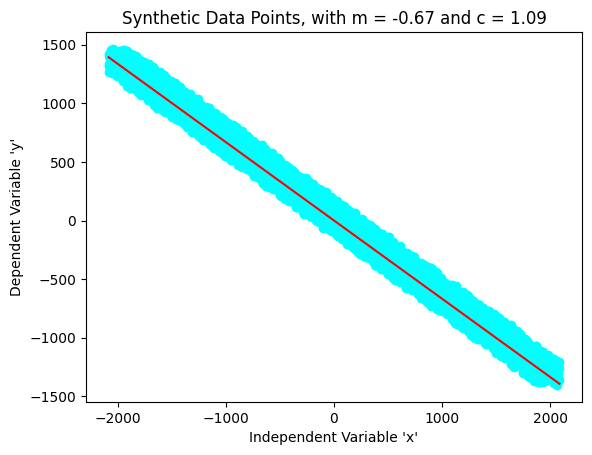

In [11]:
plt.scatter(x_list, y_list , color = 'cyan')
plt.plot((x_min, x_max), (m_learnt*x_min + c_learnt, m_learnt*x_max + c_learnt), color = 'r')
plt.title('Synthetic Data Points, with m = {} and c = {}'.format(round(m_learnt, 2), round(c_learnt, 2)))
plt.xlabel("Independent Variable 'x'")
plt.ylabel("Dependent Variable 'y'")
plt.savefig('./Images/learnt_m_and_c.jpg')
plt.show()

Looks like the model has indeed fit a straight line on the given data distribution !!! 

## Slope and Intercept during the training of the model

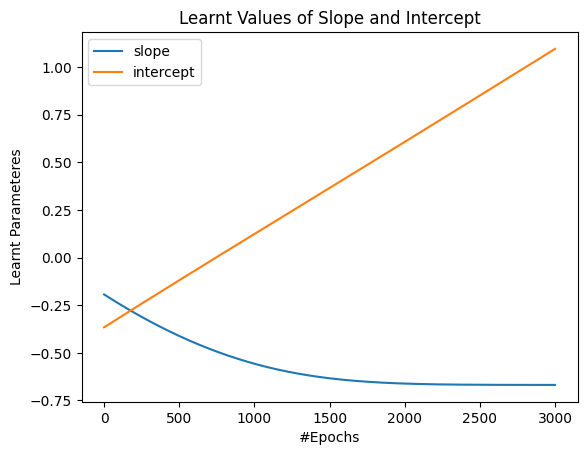

In [12]:
plt.plot(slope_list)
plt.plot(intercept_list)
plt.title('Learnt Values of Slope and Intercept')
plt.legend(['slope', 'intercept'])
plt.xlabel('#Epochs')
plt.ylabel('Learnt Parameteres')
plt.savefig('./Images/learning_m_and_c.jpg')
plt.show()

We see that during the training phase of the model, the parameters of the model change and they approach to the value for which the overall loss of the model is minimum.

This in fact, is the general idea behind any Deep Learning model. It tries to find the best suited parameters for the model, to perform a specific task, which is measured by using a suitable Loss Function for that specific task. 

### End.

I hope that you understood the basic ideas behind solving a Linear Regression problem using PyTorch.

This was a very simple example of solving a linear regression problem in 1 variable or a Univariate Regression problem. But we can even solve Multivariate Regression problems using a similar approach.

I hope that you enjoyed this tutorial ! :D

Check out the following links-

Blog on Medium: https://medium.com/@animesh7pointer/fitting-a-straight-line-on-2d-data-in-pytorch-78d0e3450876

Github Repository: https://github.com/n0obcoder/Fitting-a-Straight-Line-on-2D-Data-in-PyTorch

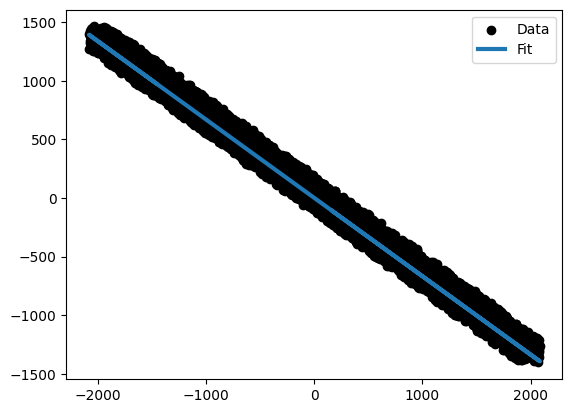

In [13]:
plt.scatter(x_list, y_list , color = 'black', label="Data")
plt.plot(data_x, pred_val_y[-1], lw=3, label="Fit")
plt.legend()
plt.show()

Adjusted R-squared
$$ {\bar {R}}^{2}=1-(1-R^{2}){n-1 \over n-p-1} $$
where p is the total number of explanatory variables in the model (excluding the intercept), and n is the sample size

In [14]:
n = data_x.shape[0]  # Same for both models
p =   1

r2 = r2_score(data_y.numpy(), pred_val_y[-1].numpy())

adj_r2 = 1 - ( 1 - r2)*((n -1)/(n - p - 1))

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

R-squared: 0.9899
Adjusted R-squared: 0.9899


## Chi-Square

In [25]:
num = (data_y.numpy() - pred_val_y[-1].numpy())**2
dem = (data_y.numpy())**2

chi_sq = np.sum(num/dem)
dof = len(data_x) - 2 
red_chi = chi_sq/dof
#chi_sq
print("dof", dof)
print(f"Chi-squared: {chi_sq:.4f}")
print(f"Reduced-squared: {red_chi:.4f}")

dof 9998
Chi-squared: 11701392.0000
Reduced-squared: 1170.3733


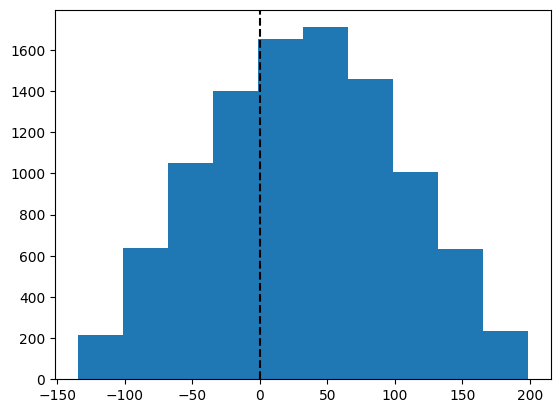

In [16]:

#plt.scatter(x_list, y_list , color = 'black', label="Data")
plt.hist(data_y - pred_val_y[-1], label="Data - Prediction")
plt.axvline(x=0, color= "black", linestyle= "dashed")
#plt.legend()
plt.show()

In [17]:
error = (data_y - pred_val_y[-1])
print(len(error))
#error

10000


In [18]:
sd = torch.std(error)
sd

tensor(70.1232)

In [19]:
torch.mean(error)

tensor(32.4302)

In [20]:
new_data = torch.normal(0, sd, size=(1, num_points))
simulated_data = torch.reshape(new_data, (-1, len(new_data)))
#simulated_data
#torch.reshape(new_data[len(new_data), -1]

In [21]:
mu = torch.mean(error)
sigma = torch.std(error)
#normed_data=(error - mu)/sigma
normed_data = error/sigma
print(stats.kstest(normed_data,'norm'))
print(stats.kstest(error, simulated_data))

KstestResult(statistic=array([0.18224129]), pvalue=array([4.09035609e-291]), statistic_location=array([0.58802217]), statistic_sign=array([-1.]))
KstestResult(statistic=array([0.1828]), pvalue=array([2.32286908e-146]), statistic_location=array([41.74754715]), statistic_sign=array([-1.]))


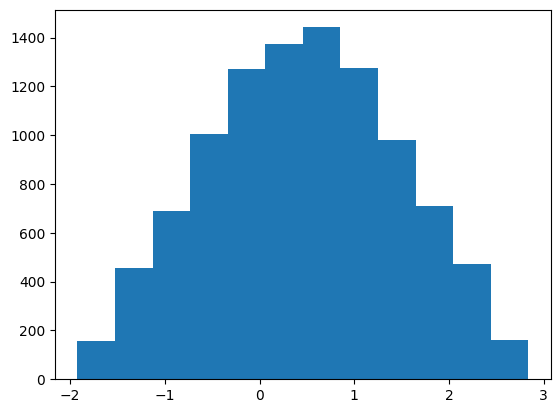

In [22]:
plt.hist(normed_data, bins=12)
plt.show()

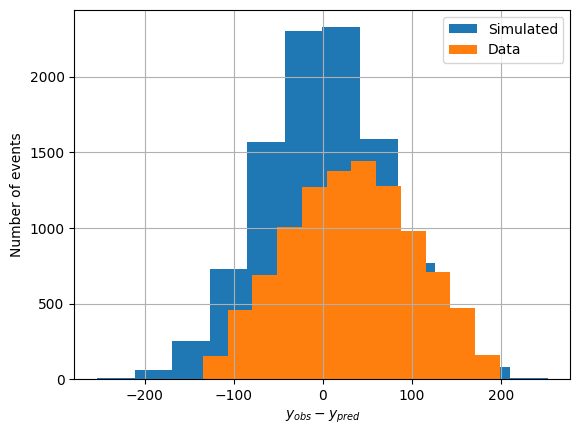

In [23]:
plt.hist(simulated_data, bins= 12, label="Simulated")
plt.hist(error, bins=12, label="Data")
plt.xlabel(r"$y_{obs} - y_{pred}$")
plt.ylabel(r"Number of events")
plt.legend()
plt.grid()
plt.show()